# P3 - Modeling & Predictions

## PART I - Prediction Model for GHG Emission

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_pickle('./tmp/df_cleaned.gzip')


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 204 to 6715
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            1165 non-null   object 
 1   PrimaryPropertyType     1165 non-null   object 
 2   Neighborhood            1165 non-null   object 
 3   NumberofFloors          1165 non-null   float64
 4   PropertyGFATotal        1165 non-null   float64
 5   LargestPropertyUseType  1156 non-null   object 
 6   ENERGYSTARScore         736 non-null    float64
 7   SourceEUI(kBtu/sf)      1165 non-null   float64
 8   SiteEnergyUse(kBtu)     1165 non-null   float64
 9   TotalGHGEmissions       1165 non-null   float64
 10  GHGEmissionsIntensity   1072 non-null   float64
 11  BuildingAge             1144 non-null   float64
 12  Distance                1165 non-null   float64
dtypes: float64(9), object(4)
memory usage: 127.4+ KB


In [4]:
# on regarde simplement quelles sont les formes des features
feats = pd.DataFrame(
    columns=['feature', 'std', 'skew', 'var', 'kur']
)
agg_func = ['std', 'skew', 'var', 'kurtosis']

for f in df.select_dtypes(['float', 'int']):
    res = df[f].agg(agg_func)
    feats = feats.append(
        {'feature': f, 'std': res[0], 'skew': res[1],
            'var': res[2], 'kur': res[3]},
        ignore_index=True)

feats


,feature,std,skew,var,kur
0,NumberofFloors,1.592644e+00,1.114123,2.536515e+00,0.996001
1,PropertyGFATotal,3.415116e+04,1.588516,1.166302e+09,2.049079
2,ENERGYSTARScore,2.847956e+01,-0.697310,8.110854e+02,-0.595726
3,SourceEUI(kBtu/sf),6.537177e+01,0.215919,4.273468e+03,-0.832942
4,SiteEnergyUse(kBtu),1.933526e+06,1.215272,3.738522e+12,0.899398
5,TotalGHGEmissions,4.935937e+01,1.425074,2.436347e+03,1.390636
6,GHGEmissionsIntensity,7.319455e-01,0.981375,5.357442e-01,0.176809
7,BuildingAge,3.210466e+01,0.144813,1.030709e+03,-1.067936
8,Distance,2.090586e+00,0.717430,4.370551e+00,-0.232689


### Predition Function

In [5]:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from datetime import datetime


prediction = 'TotalGHGEmissions'
removed_features = 'ENERGYSTARScore'

X = df.drop([prediction, removed_features], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


def runModel(
    model, 
    params={},
    pre_processing_steps = [
                ("imputer", SimpleImputer()),
                ("scaler", StandardScaler(with_mean=False))
            ]
    ):
    start_time = datetime.now()
    # categorical features : they are only nominal (not cardinal),
    # thus we could encode them with OneHotEncoder (not OrdinalEncoder)
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")


    numeric_transformer = Pipeline(
        steps = pre_processing_steps
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model)]
    )

    reg.fit(X_train, y_train)

    # by default, add a parameter for imputer, for all model's grid search
    # params["preprocessor__num__imputer__strategy"] = ["mean", "median"]

    gs = GridSearchCV(
        estimator=reg,
        cv=5,
        param_grid=params,
        scoring=('r2', 'neg_mean_absolute_error'),
        refit='r2',
        return_train_score=True,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)
    end_time = datetime.now()

    ellapsed_time = (end_time - start_time).total_seconds()
    y_pred = gs.predict(X_test)

    ret = {
        'model': type(model).__name__,
        'compute_time': ellapsed_time,
        'best_params': gs.best_params_,
        'RMSE': np.sqrt(mean_squared_error(y_pred, y_test)),
        'MAE': mean_absolute_error(y_pred, y_test),
        'R2': r2_score(y_pred, y_test),
        'cv_results': gs.cv_results_,
        'model_train_score': gs.score(X_train, y_train),
        'model_test_score': gs.score(X_test, y_test)
    }

    # TODO print validation curve : https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

    return ret


In [6]:

# Dummy regressor as for testing
runModel(DummyRegressor(strategy="mean"));


### Preprocessing Optimization

We use a simple Linear Regression to assess what are the best pre processing steps to consider: which ones optimizes our results

In [7]:
# Regressor as a baseline
def best_preprocessing_params():
    parameters = {
        # "preprocessor__num__imputer__strategy" : ["mean", "median"]
        "preprocessor__num__imputer__strategy" : ["mean"]
    }

    model = LinearRegression()

    ret0 = runModel(model, parameters)
    ret0['testcase'] = 'No preprocessing'

    ret1 = runModel(model, parameters, [("imputer", SimpleImputer())])
    ret1['testcase'] = 'SimpleImputer only'

    ret2 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler())])
    ret2['testcase'] = 'SimpleImputer + MinMax'

    ret3 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler()), ("scaler", StandardScaler(with_mean=False))])
    ret3['testcase'] = 'SimpleImputer + Minmax + StdScaler(w/o mean)'

    ret4 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler(with_mean=False))])
    ret4['testcase'] = 'SimpleImputer + StdScaler(w/o mean)'

    ret5 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler())])
    ret5['testcase'] = 'SimpleImputer + StdScaler'

    res_baseline = pd.DataFrame.from_dict([ret1, ret2, ret3, ret4, ret5])


    res_baseline_draw = res_baseline.set_index('testcase')
    return res_baseline_draw



In [8]:

# need to compute several times, since we have side effects on memory allocation on jupyter notebooks at firsts launches, which produces biased / false results for compute time (difference is very small)
res_baseline_draw = best_preprocessing_params()
for i in range(5):
    res_baseline_draw = res_baseline_draw.append(best_preprocessing_params())
    # res_baseline_draw = best_preprocessing_params()

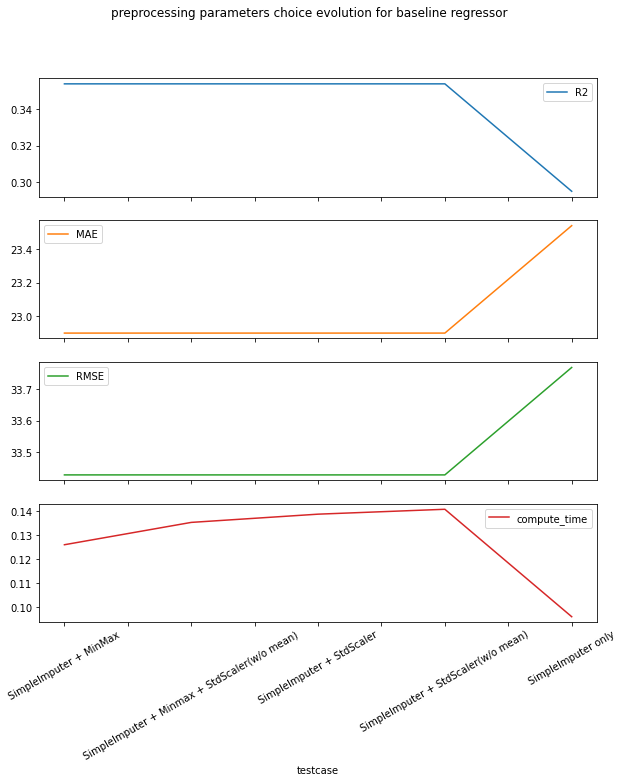

In [9]:
res_baseline_draw[['R2', 'MAE', 'RMSE', 'compute_time']].groupby(level=0).mean().plot(rot=30, kind='line',  subplots=True, figsize=(10, 10), 
    title='preprocessing parameters choice evolution for baseline regressor');

SimpleImputer is mandatory, otherwise we have errors of missing values for training the model

Then, in order to reduce the error & raise the score, we have to choose at least a StandardScaler or a MinMax (both at the same time are not providing a significant improvement, with a slight increase in compute time)

> We choose to keep SimpleImputer + MinMax + StdScaler(w/o mean), which provides a slightly shorter compute time, for the same benefit

### Models compute

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from xgboost import XGBRegressor
import os
from dataclasses import dataclass
from datetime import datetime

xgb.set_config(verbosity=0)


@dataclass
class ModelCompute:
    model: object
    params: dict



In [11]:

hyper_params_baseline = dict()

hyper_params_baseline['parameters_svr'] = {
    # 'regressor__C': np.logspace(-2, -1, 10),
    # 'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

hyper_params_baseline['parameters_rf'] = {
    # 'regressor__n_estimators': [10, 50, 100, 300, 500],
    # 'regressor__min_samples_leaf': [1, 3, 5, 10],
    # 'regressor__max_features': ['auto', 'sqrt', 'log2'],

    # 'regressor__max_depth' : [5, 15, 25, 50],
    # 'regressor__min_samples_split': [2, 5, 10],
    # 'regressor__bootstrap' : [True, False],
}

hyper_params_baseline['parameters_knn'] = {
    # 'regressor__n_neighbors': [2, 4, 8, 10, 16]
}

hyper_params_baseline['parameters_xgb'] = {
    'regressor__n_estimators': [10],
    # 'regressor__n_estimators': [200, 500, 1000],
    # 'regressor__max_depth': [2, 5, 10],
    # 'regressor__eval_metric': ["rmse"],
}

hyper_params_baseline['parameters_ridge'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 100)
}

hyper_params_baseline['parameters_lasso'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50)
}

hyper_params_baseline['parameters_net'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50),
    # 'regressor__l1_ratio' : np.logspace(-5, 5, 200),
}

hyper_params = hyper_params_baseline

models = [
    # ModelCompute(DummyRegressor(strategy="mean"), {}),
    ModelCompute(LinearRegression(n_jobs=os.cpu_count()), {}),
    ModelCompute(KNeighborsRegressor(), hyper_params['parameters_knn']),
    ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_rf']),
    ModelCompute(XGBRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_xgb']),
    ModelCompute(LinearSVR(), hyper_params['parameters_svr']),
    ModelCompute(Ridge(), hyper_params['parameters_ridge']),
    ModelCompute(Lasso(tol=1000), hyper_params['parameters_lasso']),
    ModelCompute(ElasticNet(tol=1000), hyper_params['parameters_net'])
]

results = pd.DataFrame(
    columns=['model', 'compute_time', 'best_params', 'RMSE', 'MAE',
             'R2', 'cv_results', 'model_train_score', 'model_test_score']
)

print(f'computing models with {os.cpu_count()} cpus')

start_time = datetime.now()
for mod in models:
    print(f'computing model {type(mod.model).__name__}...', end='')
    ret = runModel(mod.model, mod.params)
    results = results.append(ret, ignore_index=True)
    print('done.')
print(f'finished compute models in {datetime.now() - start_time}')

results.T



computing models with 32 cpus
computing model LinearRegression...done.
computing model KNeighborsRegressor...done.
computing model RandomForestRegressor...done.
computing model XGBRegressor...done.
computing model LinearSVR...done.
computing model Ridge...done.
computing model Lasso...done.
computing model ElasticNet...done.
finished compute models in 0:00:20.500926


,0,1,2,3,4,5,6,7
model,LinearRegression,KNeighborsRegressor,RandomForestRegressor,XGBRegressor,LinearSVR,Ridge,Lasso,ElasticNet
compute_time,0.112635,0.083161,0.701667,19.196443,0.053158,0.062997,0.049373,0.045744
best_params,{},{},{},{'regressor__n_estimators': 10},{},{},{},{}
RMSE,33.426342,32.663922,13.508134,14.813268,35.564493,33.028137,35.31802,36.166299
MAE,22.89668,21.236146,6.708881,7.328076,20.633307,22.56798,23.111932,24.07048
R2,0.354027,0.114342,0.915578,0.898311,-0.221133,0.338908,0.22382,-0.574164
cv_results,"{'mean_fit_time': [0.028581619262695312], 'std...","{'mean_fit_time': [0.00987558364868164], 'std_...","{'mean_fit_time': [0.26344938278198243], 'std_...","{'mean_fit_time': [18.527247285842897], 'std_f...","{'mean_fit_time': [0.009528017044067383], 'std...","{'mean_fit_time': [0.012191438674926757], 'std...","{'mean_fit_time': [0.008847713470458984], 'std...","{'mean_fit_time': [0.009679937362670898], 'std..."
model_train_score,0.658557,0.760151,0.990563,0.987578,0.537176,0.649668,0.531558,0.504534
model_test_score,0.573005,0.592261,0.930267,0.916141,0.516631,0.583118,0.523308,0.500134


In [12]:
results

,model,compute_time,best_params,RMSE,MAE,R2,cv_results,model_train_score,model_test_score
0,LinearRegression,0.112635,{},33.426342,22.896680,0.354027,"{'mean_fit_time': [0.028581619262695312], 'std...",0.658557,0.573005
1,KNeighborsRegressor,0.083161,{},32.663922,21.236146,0.114342,"{'mean_fit_time': [0.00987558364868164], 'std_...",0.760151,0.592261
2,RandomForestRegressor,0.701667,{},13.508134,6.708881,0.915578,"{'mean_fit_time': [0.26344938278198243], 'std_...",0.990563,0.930267
3,XGBRegressor,19.196443,{'regressor__n_estimators': 10},14.813268,7.328076,0.898311,"{'mean_fit_time': [18.527247285842897], 'std_f...",0.987578,0.916141
4,LinearSVR,0.053158,{},35.564493,20.633307,-0.221133,"{'mean_fit_time': [0.009528017044067383], 'std...",0.537176,0.516631
5,Ridge,0.062997,{},33.028137,22.567980,0.338908,"{'mean_fit_time': [0.012191438674926757], 'std...",0.649668,0.583118
6,Lasso,0.049373,{},35.318020,23.111932,0.223820,"{'mean_fit_time': [0.008847713470458984], 'std...",0.531558,0.523308
7,ElasticNet,0.045744,{},36.166299,24.070480,-0.574164,"{'mean_fit_time': [0.009679937362670898], 'std...",0.504534,0.500134


In [13]:
results.to_pickle('tmp/results.gzip')

### Models Comparison

In [14]:
results = pd.read_pickle('tmp/results.gzip')


In [15]:
result = results.set_index('model')


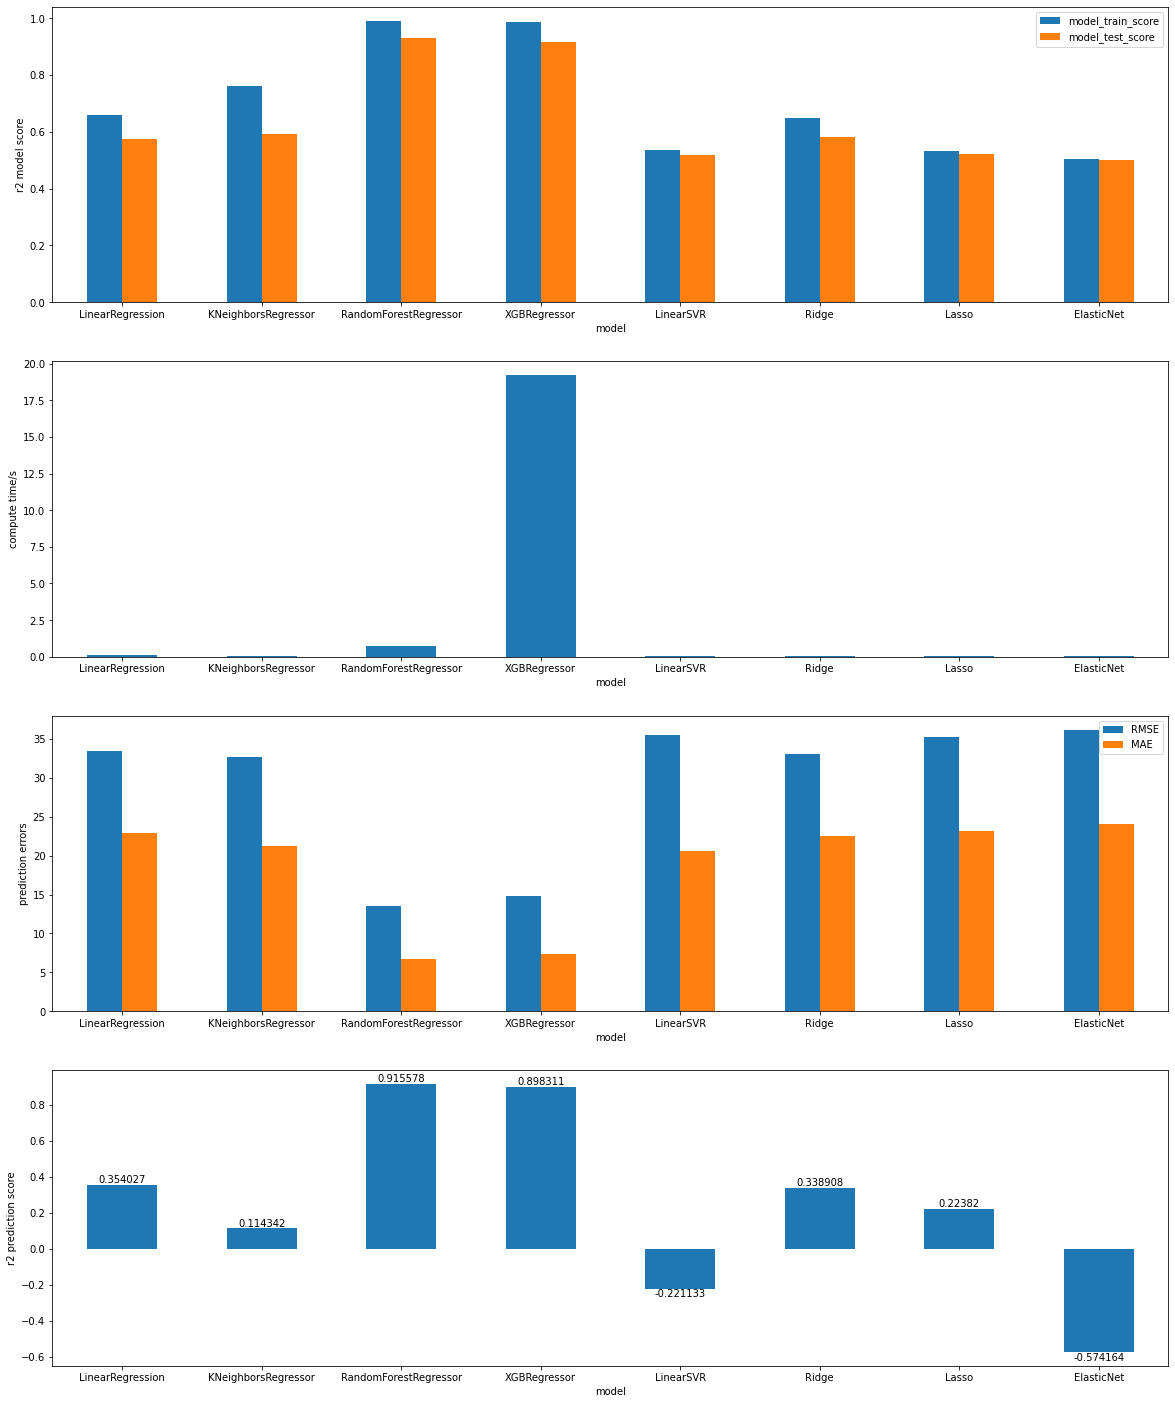

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(20, 25))

result[['model_train_score', 'model_test_score']].plot(
    rot=0, kind='bar', ylabel='r2 model score', ax=ax0)
result['compute_time'].plot(rot=0, kind='bar', ylabel='compute time/s', ax=ax1)
result[['RMSE', 'MAE']].plot(
    rot=0, kind='bar', ylabel='prediction errors',  ax=ax2)
result['R2'].plot(rot=0, kind='bar', ylabel='r2 prediction score',  ax=ax3)
for r in ax3.containers:
    ax3.bar_label(r)


### Model Choice

As we can see, with default hyper parameters, the most interesting model is RFR, because it's the one with the best ratio score / error / compute time.

In the next section we run this model with several hyper parameters and cv.

Please note, one could consider also:
* XGBoost: by far has the longest compute time, despite could provide good results, but most probably not a lot better than RFR because the improvement margin is tight
* KNR: has a pretty good compute time despite having a lower score. But, after several hyper parameters tuning, could potentially raise to acceptable thresholds



In [17]:
parameters_rf = {
    "preprocessor__num__imputer__strategy" : ["mean"],
    'regressor__n_estimators': [100, 300, 500],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],

    'regressor__max_depth' : [5, 15, 25, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__bootstrap' : [True, False],
}

mod = ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf)

start_time = datetime.now()
print(f'computing model {type(mod.model).__name__}...', end='')
ret = runModel(mod.model, mod.params)
print(f'done in {datetime.now() - start_time}')

computing model RandomForestRegressor...done in 0:02:12.341396


In [18]:
print(ret['best_params'])
print(ret['R2'])
print(ret['MAE'])
print(ret['RMSE'])

{'preprocessor__num__imputer__strategy': 'mean', 'regressor__bootstrap': True, 'regressor__max_depth': 25, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
0.9135199721024346
6.583385064377683
13.651816076191963


### Predictions

In [19]:

from sklearn.ensemble import RandomForestRegressor

def predict_best_model(
    X_predict, 
    _X_train=X_train, 
    _y_train=y_train,
    regressor=RandomForestRegressor(
        n_jobs=os.cpu_count(),
        bootstrap=True,
        max_depth=15,
        max_features='auto',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=500
        )
    ):   

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    numeric_transformer = Pipeline(
        steps = [
                ("imputer", SimpleImputer(strategy='mean')),
                ("scaler", StandardScaler(with_mean=False))
            ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    reg = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor)
         ]
    )
    
    reg.fit(_X_train, _y_train)
    return reg.predict(X_predict)


#### Precision Visualization

0.4275936685909889


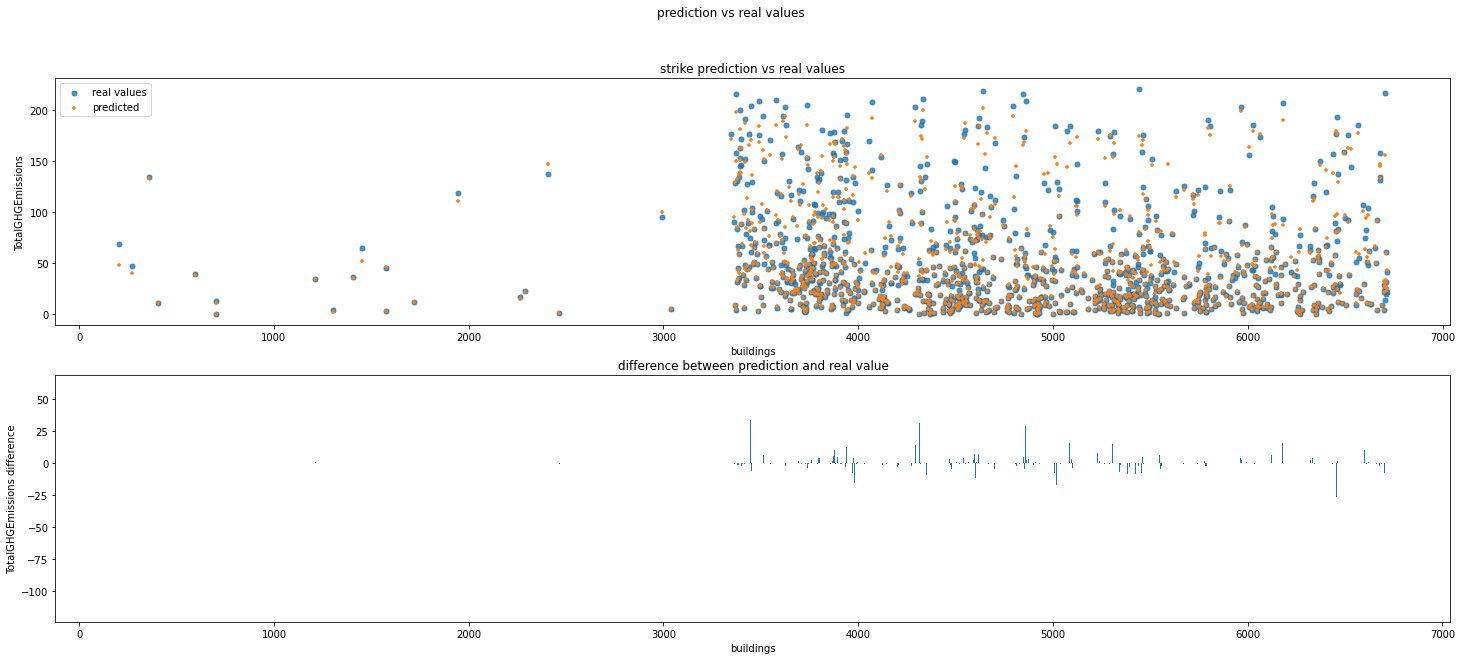

In [20]:
def show_strikes(_X_real, _y_real = y, show_graph=True, title='prediction vs real values'):
    
    y_pred = predict_best_model(_X_real)
    differences = _y_real-y_pred

    if show_graph:
        fig, ax = plt.subplots(2, 1, figsize=(25,10))
        fig.suptitle(title)
        ax[0].scatter(_y_real.index, _y_real.values, s=25, marker='o', alpha=0.8, label='real values')
        ax[0].scatter(_y_real.index, y_pred, s=20, marker='+', label='predicted')
        ax[0].set_xlabel('buildings')
        ax[0].set_ylabel('TotalGHGEmissions')
        ax[0].legend()
        ax[0].set_title('strike prediction vs real values')

        ax[1].bar(_y_real.index, differences)
        ax[1].set_xlabel('buildings')
        ax[1].set_ylabel('TotalGHGEmissions difference')
        ax[1].set_title('difference between prediction and real value')

    return differences

print(show_strikes(X).mean())


#### Precision by Neighborhood

In [21]:
print(X.Neighborhood.unique())

byNeighborsResult = {}

for n in X.Neighborhood.unique():
    XbyNeighbor = X.groupby('Neighborhood').get_group(n)
    byNeighborsResult[n] = show_strikes(XbyNeighbor, y[XbyNeighbor.index], False)

by_neighbors = pd.DataFrame.from_dict(byNeighborsResult)


['DOWNTOWN' 'GREATER DUWAMISH' 'LAKE UNION' 'NORTHWEST' 'SOUTHEAST' 'EAST'
 'BALLARD' 'MAGNOLIA / QUEEN ANNE' 'NORTHEAST' 'CENTRAL' 'NORTH'
 'DELRIDGE' 'SOUTHWEST' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']


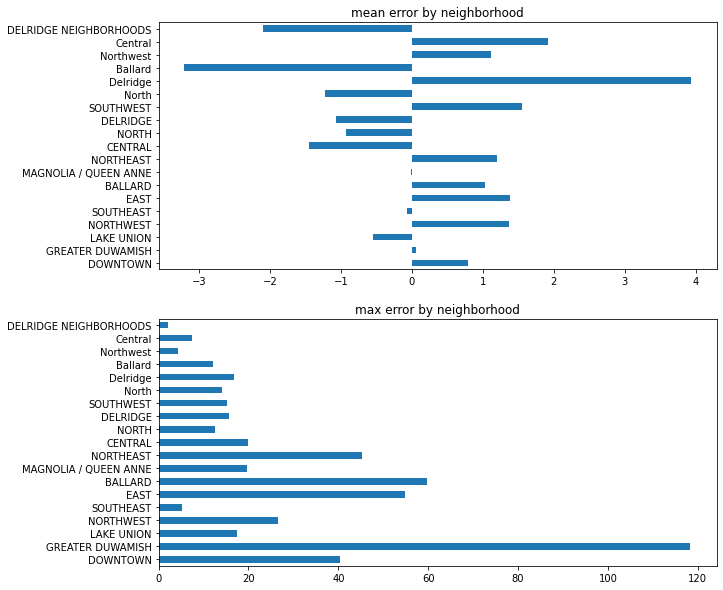

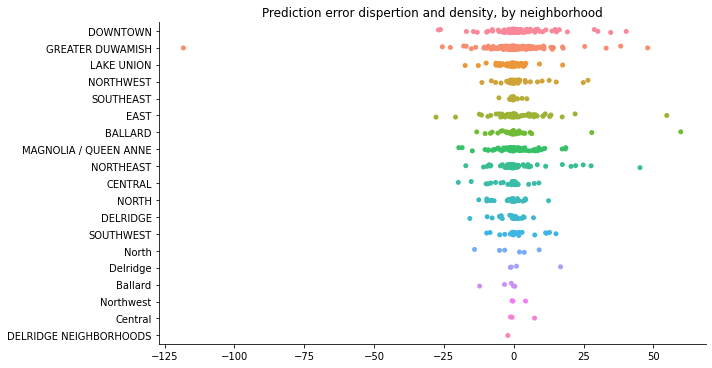

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

by_neighbors.mean().plot(kind='barh', title='mean error by neighborhood', ax=ax[0])
by_neighbors.abs().max().plot(kind='barh', title='max error by neighborhood', ax=ax[1])
sns.catplot(data=by_neighbors, height = 5, aspect=2, orient='h').set(title='Prediction error dispertion and density, by neighborhood')

We can see our model: 
* tends to lower the reality
* is very efficient for some neighborhoods : delridge, central, northwest, ballard, north

#### Precisions for Buildings' given characteristics 

* Building Type
* Gross Floor Area
* Number of Floors
* Distance

In [23]:
X

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),GHGEmissionsIntensity,BuildingAge,Distance
204,NonResidential,Retail Store,DOWNTOWN,4.0,111077.0,NaN,190.200000,0.000000e+00,0.24,NaN,0.266844
272,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,6.0,98370.0,Office,207.500000,6.525887e+06,0.20,NaN,0.123253
358,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,3.0,76598.0,Office,169.800000,4.476997e+06,1.63,NaN,3.112686
406,NonResidential,Non-Refrigerated Warehouse,LAKE UNION,1.0,66968.0,NaN,73.800000,1.575581e+06,0.06,NaN,0.947467
593,NonResidential,Other,GREATER DUWAMISH,1.0,54171.0,NaN,35.600000,1.008645e+06,0.70,NaN,2.426347
...,...,...,...,...,...,...,...,...,...,...,...
6708,Nonresidential COS,Mixed Use Property,CENTRAL,1.0,20050.0,Other - Recreation,175.199997,1.813404e+06,3.03,22.0,1.538001
6710,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1.0,18261.0,Other - Recreation,126.000000,9.320821e+05,1.11,34.0,5.001076
6712,Nonresidential COS,Other,DOWNTOWN,1.0,16000.0,Other - Recreation,114.199997,9.502762e+05,2.01,12.0,0.996345
6714,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1.0,14101.0,Other - Recreation,105.300003,7.194712e+05,1.57,27.0,5.528963


In [24]:
# By Building Type
byCategory = []

for b in X.BuildingType.unique():
    indexes = X.groupby('BuildingType').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'type':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)


,type,numberOfRecords,RMSE,MAE,R2
0,NonResidential,1087,7.079229,3.042025,0.976509
1,SPS-District K-12,5,0.456444,0.411549,0.998037
2,Nonresidential COS,61,11.093938,5.993634,0.957624
3,Campus,11,13.157642,8.287772,0.928549
4,Nonresidential WA,1,0.207060,0.207060,NaN


In [25]:
# By Gross Floor Area
byCategory = []
slices = ['XS', 'S', 'M', 'L', 'XL', 'XXL']

c, bins = pd.cut(X['PropertyGFATotal'], 6, labels=slices, retbins=True)
print(bins)
for b in slices:
    indexes = c.to_frame().groupby('PropertyGFATotal').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'PropertyGFATotal':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)


[ 11114.591  39686.5    68088.     96489.5   124891.    153292.5
 181694.   ]


,PropertyGFATotal,numberOfRecords,RMSE,MAE,R2
0,XS,605,8.156530,3.020528,0.962718
1,S,306,6.656277,3.377491,0.980779
2,M,117,4.523106,2.505293,0.990607
3,L,72,7.027130,3.869413,0.981454
4,XL,41,8.867140,5.267372,0.974436
5,XXL,24,5.823606,3.635144,0.984882


In [26]:
# By Number Of Floors
byCategory = []

for b in X.NumberofFloors.unique():
    indexes = X.groupby('NumberofFloors').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'type':b, 'NumberofFloors' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)

,type,NumberofFloors,RMSE,MAE,R2
0,4.0,120,7.351587,3.353105,0.978980
1,6.0,48,4.021831,2.434097,0.993272
2,3.0,211,9.655982,3.352082,0.943692
3,1.0,368,7.127766,3.293855,0.978347
4,2.0,311,6.386695,3.040129,0.980892
5,7.0,18,4.771069,2.255645,0.991550
6,0.0,21,8.128807,4.682721,0.980177
7,5.0,60,6.241691,2.830820,0.978246
8,8.0,6,6.838031,4.164497,0.966364
9,9.0,2,5.112744,4.959206,0.723935


In [27]:
# By Distance range
byCategory = []
slices = ['0', '1', '2', '3', '4', '5']

c = pd.qcut(X['Distance'], 6, labels=slices)

for b in slices:
    indexes = c.to_frame().groupby('Distance').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'Distance':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)

,Distance,numberOfRecords,RMSE,MAE,R2
0,0,195,7.605716,3.416857,0.974894
1,1,194,7.214808,3.540825,0.976784
2,2,194,5.258112,2.948321,0.985861
3,3,194,4.836990,2.386682,0.989795
4,4,193,9.541692,2.945962,0.955413
5,5,195,8.663542,3.996148,0.968882


#### Precision depending of GHGEmissions range

We evaluate the strike of our model for different range of GHGEmissions

average LOW difference:  1.7029495074167769
average MID difference:  6.295086301501896
average HIGH difference:  13.073225884965362


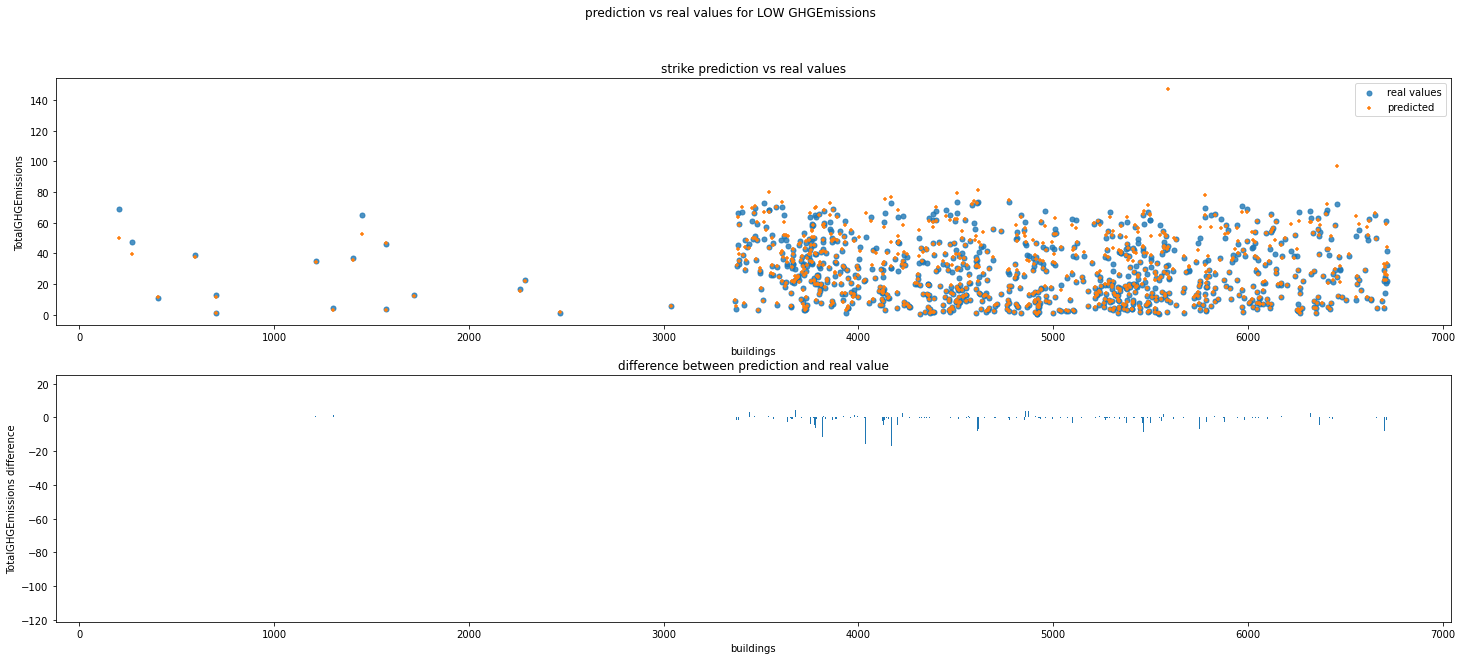

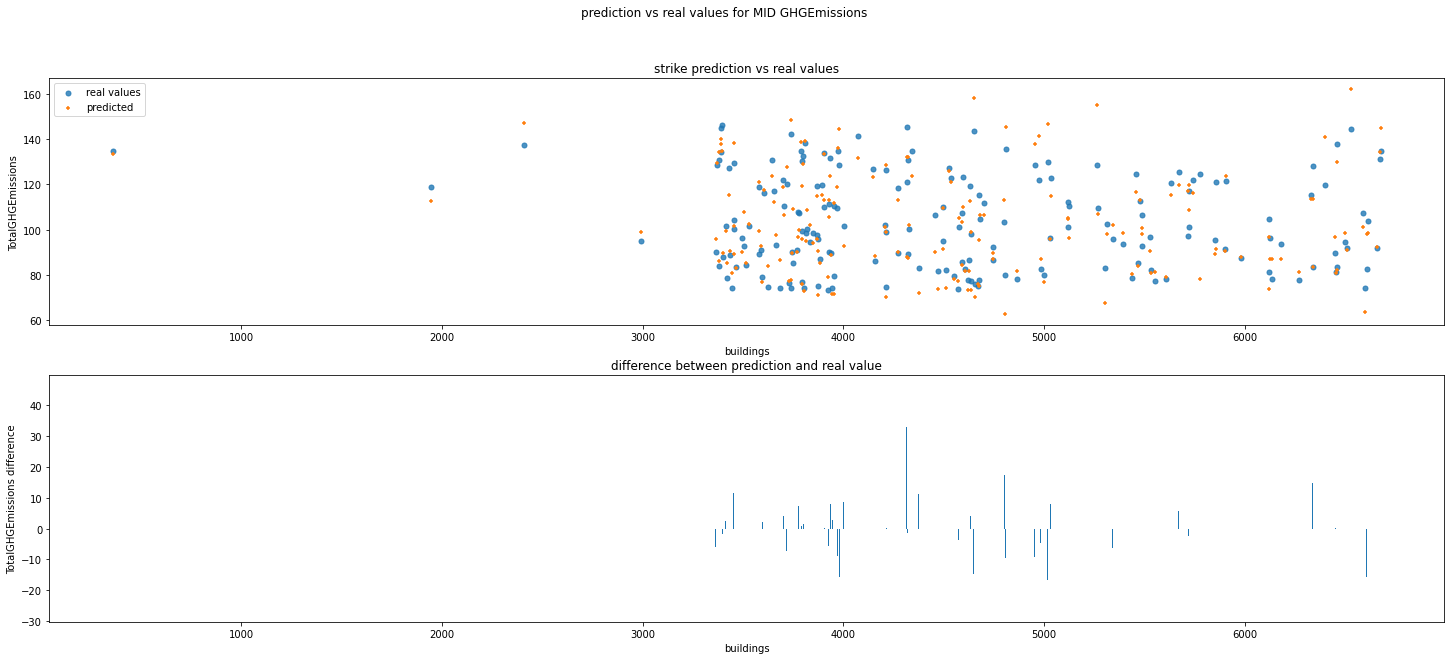

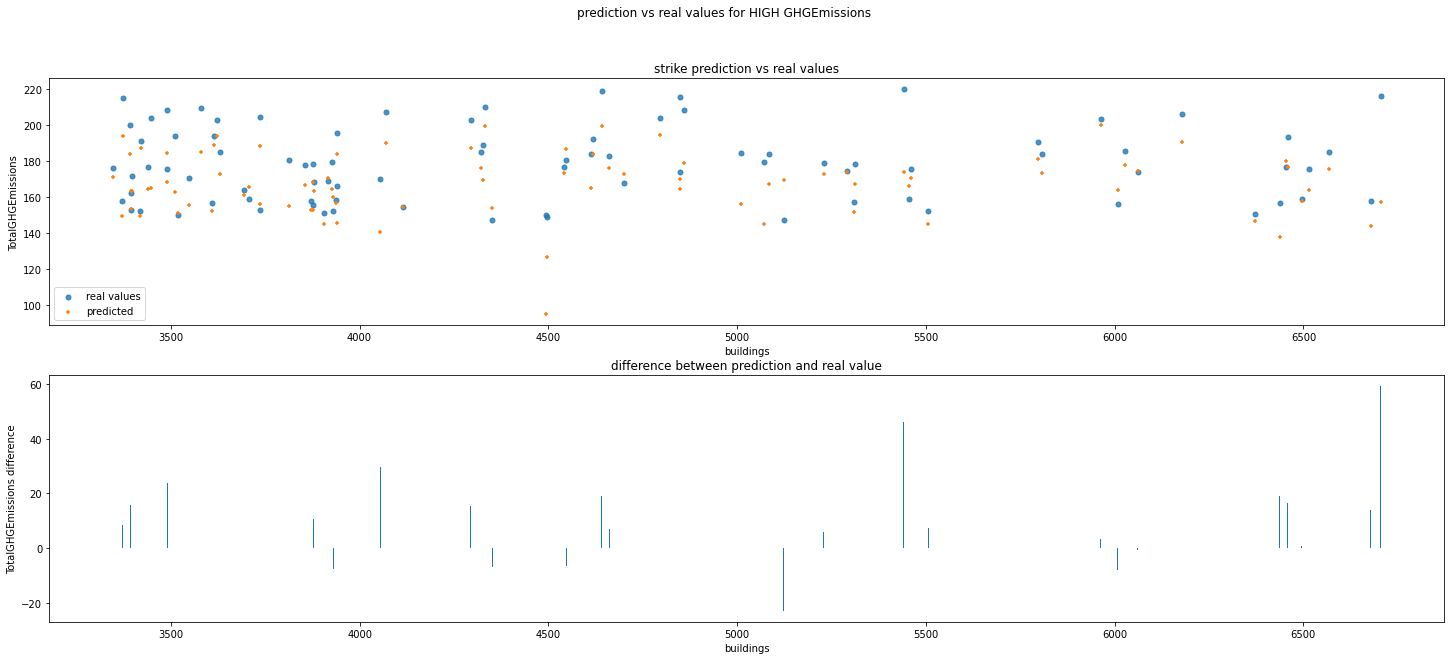

In [28]:

slices = ['low', 'mid', 'high']

c = pd.cut(y, 3, labels=slices)

indexes_low = c.to_frame().groupby('TotalGHGEmissions').get_group('low').index.values
X_low = X.loc[indexes_low]
y_low = y.loc[indexes_low]
low_diff = show_strikes(X_low, y_low, True, 'prediction vs real values for LOW GHGEmissions')
print('average LOW difference: ', low_diff.abs().mean())


indexes_mid = c.to_frame().groupby('TotalGHGEmissions').get_group('mid').index.values
X_mid = X.loc[indexes_mid]
y_mid = y.loc[indexes_mid]
mid_diff = show_strikes(X_mid, y_mid, True, 'prediction vs real values for MID GHGEmissions')
print('average MID difference: ', mid_diff.abs().mean())


indexes_high = c.to_frame().groupby('TotalGHGEmissions').get_group('high').index.values
X_high = X.loc[indexes_high]
y_high = y.loc[indexes_high]
high_diff = show_strikes(X_high, y_high, True, 'prediction vs real values for HIGH GHGEmissions')
print('average HIGH difference: ', high_diff.abs().mean())

### Conclusion

Our model tends to be more precise for low values of TotalGHGEmissions.

At the opposite, for hig values the model performs approx. 10 times lower.

To recap, in a real situation we would like to detect the buildings generating high GHG values. 

Thanks to our model, we'll be able to predict those values, knowing that for high results it tends to produce a figure slightly behind the reality, especially for particular neighborhoods

## PART II - Energy Used and EnergyStar

The second part of the study is to predict SiteEnergyUsed, and check if EnergyStar score is of any interest

### EnergyStar Score Impact

In [29]:
prediction = 'TotalGHGEmissions'


X = df.drop([prediction], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [30]:
#  We use the same model RFR, but we run another CV

parameters_rf = {
    "preprocessor__num__imputer__strategy" : ["mean"],
    'regressor__n_estimators': [100, 300, 500],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],

    'regressor__max_depth' : [5, 15, 25, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__bootstrap' : [True, False],
}

mod = ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf)

start_time = datetime.now()
print(f'computing model {type(mod.model).__name__}...', end='')
ret = runModel(mod.model, mod.params)
print(f'done in {datetime.now() - start_time}')
print(ret['best_params'])
print(ret['R2'])
print(ret['MAE'])
print(ret['RMSE'])



computing model RandomForestRegressor...done in 0:02:18.956074
{'preprocessor__num__imputer__strategy': 'mean', 'regressor__bootstrap': True, 'regressor__max_depth': 50, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
0.9038071176014162
7.069177253218886
14.43057630612845


The parameters are pretty much the same, the scores are also very good

### SiteEnergyUse prediction

In [31]:
prediction = 'SiteEnergyUse(kBtu)'
removed_features = 'ENERGYSTARScore'

X = df.drop([prediction, removed_features], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [32]:
y.describe()

count    1.165000e+03
mean     2.385423e+06
std      1.933526e+06
min      0.000000e+00
25%      9.680263e+05
50%      1.770028e+06
75%      3.321036e+06
max      8.926736e+06
Name: SiteEnergyUse(kBtu), dtype: float64

In [33]:
parameters_rf = {
    "preprocessor__num__imputer__strategy" : ["mean"],
    'regressor__n_estimators': [100, 300, 500],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],

    'regressor__max_depth' : [5, 15, 25, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__bootstrap' : [True, False],
}

mod = ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf)

start_time = datetime.now()
print(f'computing model {type(mod.model).__name__}...', end='')
ret = runModel(mod.model, mod.params)
print(f'done in {datetime.now() - start_time}')
print(ret['best_params'])
print(ret['R2'])
print(ret['MAE'])
print(ret['RMSE'])

computing model RandomForestRegressor...done in 0:02:11.870307
{'preprocessor__num__imputer__strategy': 'mean', 'regressor__bootstrap': True, 'regressor__max_depth': 15, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
0.7053324760190617
439013.36952035245
820125.5489867742


The score is lower for this feature, our model is less performant: R2 ≃ 0.85

## APPENDIX

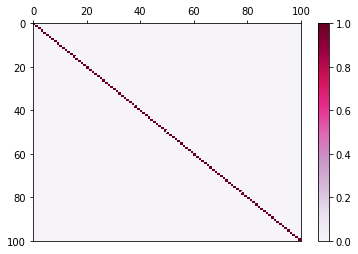

In [34]:
# Gramm matrix - WIP

from sklearn import metrics
import matplotlib

def gram():
    
    kmatrix = metrics.pairwise.rbf_kernel(X[X.select_dtypes(exclude='object').columns].dropna(), gamma=0.01)
    kmatrix100 = kmatrix[:100, :100]
    # dessiner la matrice
    plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd)

    # rajouter la légende
    plt.colorbar()

    # retourner l'axe des ordonnées
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()

    # afficher l'image
    plt.show()

gram()